# Quantum Embedding of Ising configurations

## Imports and random seed

In [23]:
import os
import random
import numpy as np
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from math import ceil, log2

In [24]:
seed = 2
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

## Importing the data

In [25]:
# Size of the images, the number of qubits is 2 * ceil(log2(size_image)) + 1   (Height, Width and spin channel)
image_size = 4
# Ising infinite lattice size critical temperature
statistical_control_parameter = 2.2692 

with open('./data/ising/L={}/T={:.4f}.bin'.format(image_size, statistical_control_parameter), 'rb') as f:
    X = np.frombuffer(buffer=f.read(), dtype=np.int8, offset=0).reshape(-1, image_size, image_size)

idx = np.random.randint(X.shape[0])
image = X[idx]

In [26]:
image

array([[-1, -1, -1, -1],
       [-1,  1,  1,  1],
       [-1, -1, -1,  1],
       [ 1,  1, -1, -1]], dtype=int8)

## NEQR Quantum encoding

In [27]:
def binary_formatting(
    digit: int,
    n_bits: int,
    reverse: bool = False,
) -> str:
    r"""
    Args:
        digit (int): number whose binary representation we are computing
        n_bits (int): number of bits used in the binary representation (to handle left trailing zeros)
        reverse (bool): optionally return the binary representation of digit in reverse order (for qiskit convention)
    Returns:
        (str): binary representation of digit
    """

    binary = format(digit, '0{}b'.format(n_bits))

    if reverse:
        binary = binary[::-1]

    return binary

In [28]:
side_qubits = ceil(log2(image_size))
image_qubits = 2 * side_qubits
total_qubits = image_qubits + 1

We will assign |0> to a -1 spin and |1> to a +1 spin.

In [35]:
def image_to_circuit(
    image: np.ndarray,
    measure: bool = True,
) -> QuantumCircuit:

    image_size = image.shape[0]
    side_qubits = ceil(log2(image_size))
    image_qubits = 2 * side_qubits
    total_qubits = image_qubits + 1

    image_register = QuantumRegister(image_qubits, 'position')
    spin_register = QuantumRegister(1,'spin')

    if measure:
        classical_register = ClassicalRegister(image_qubits + 1, 'classical register')
        qc = QuantumCircuit(spin_register, image_register, classical_register)

    else:
        qc = QuantumCircuit(spin_register, image_register)

    qc.i(0)
    for i in range(1, image_register.size + 1):
        qc.h(i)

    qc.barrier()

    for i in range(image_size):
        for j in range(image_size):

            if image[i, j] == 1:

                binarized_i = binary_formatting(digit=i, n_bits=side_qubits, reverse=False)
                binarized_j = binary_formatting(digit=j, n_bits=side_qubits, reverse=False)

                flip_idx = []

                for ii in range(side_qubits):
                    if binarized_i[ii] == '1':
                        flip_idx.append(ii+1)
                        qc.x(ii+1)

                for jj in range(side_qubits):
                    if binarized_j[jj] == '1':
                        flip_idx.append(jj+side_qubits+1)
                        qc.x(jj+side_qubits+1)

                if flip_idx != []:
                    qc.mcx(flip_idx, 0, mode='noancilla')

                for q in flip_idx:
                    qc.x(q)

                qc.barrier() 

    if measure:
        qc.measure(range(total_qubits), range(total_qubits))

    return qc

In [38]:
qc = image_to_circuit(image=image, measure=True)

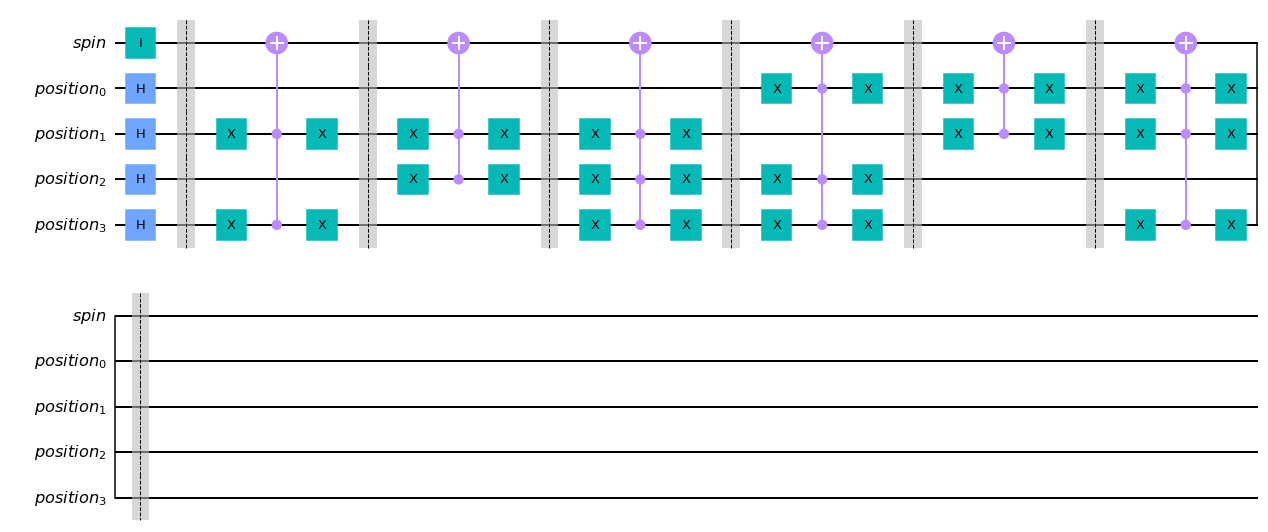

In [37]:
qc.draw(output='mpl')

In [21]:
print('Circuit dimensions')
print('Circuit depth: ', qc_image.decompose().depth())
print('Circuit size: ', qc_image.decompose().size())

qc_image.decompose().count_ops()

Circuit dimensions
Circuit depth:  122
Circuit size:  178


OrderedDict([('cx', 60),
             ('p', 45),
             ('u3', 30),
             ('h', 12),
             ('t', 12),
             ('tdg', 9),
             ('barrier', 7),
             ('measure', 5),
             ('u2', 4),
             ('id', 1)])

{'11100': 3, '00101': 4, '01001': 6, '00011': 5, '10000': 8, '11001': 8, '00000': 7, '10011': 8, '01110': 12, '01100': 4, '00110': 6, '10110': 9, '11010': 4, '01011': 6, '11110': 6, '10100': 4}


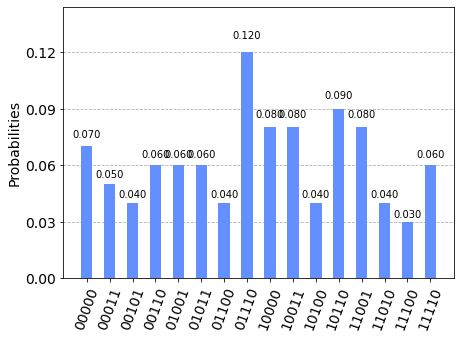

In [22]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=100)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()

print(counts_neqr)
plot_histogram(counts_neqr)